## Лабораторная работа 3. Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.

Задание:
Выберите набор данных (датасет) для решения задачи классификации или регрессии.
В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
С использованием метода train_test_split разделите выборку на обучающую и тестовую.
Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью подходящих для задачи метрик.
Произведите подбор гиперпараметра K с использованием GridSearchCV и RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели. Используйте не менее двух стратегий кросс-валидации.
Сравните метрики качества исходной и оптимальной моделей.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

#### Загрузка и анализ данных

In [2]:
# Загрузка данных
data = pd.read_csv('train.csv')

# Разделение на признаки и целевую переменную
X = data.drop('price_range', axis=1)
y = data['price_range']

# Генерация имён классов 
target_names = ["Low cost", "Medium cost", "High cost", "Very high cost"]

#### Деление на обучающую и тестовую выборки

In [3]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### Обучение базовой модели с произвольным K

In [ ]:
k_default = 3

# Обучение модели KNN с K=3
knn = KNeighborsClassifier(n_neighbors=k_default)
knn.fit(X_train, y_train)

# Предсказание и оценка модели
y_pred = knn.predict(X_test)

Разные метрики базовой модели при k=3


In [5]:
print(f"--- Метрики модели при K={k_default} ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F-score (macro):", f1_score(y_test, y_pred, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred))


--- Метрики модели при K=3 ---
Accuracy: 0.9316666666666666
Precision (macro): 0.9316558003696763
Recall (macro): 0.9316666666666666
F-score (macro): 0.931575053200765
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       150
           1       0.92      0.94      0.93       150
           2       0.90      0.88      0.89       150
           3       0.93      0.94      0.94       150

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



#### Визуализация confusion matrix

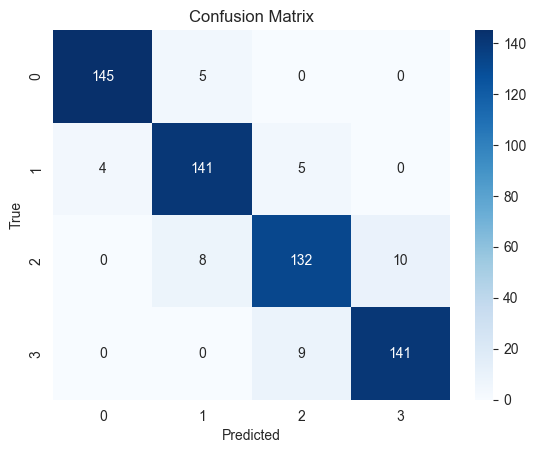

In [6]:
# Визуализация матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Подбор гиперпараметра K с GridSearchCV (стратегия KFold)

In [7]:
param_grid = {'n_neighbors': np.arange(1, 31)}
cv_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv_kfold, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("\n--- GridSearchCV ---")
print("Best parameters:", grid_search.best_params_["n_neighbors"])
print("Best score (accuracy):", grid_search.best_score_)


--- GridSearchCV ---
Best parameters: 15
Best score (accuracy): 0.9157142857142857


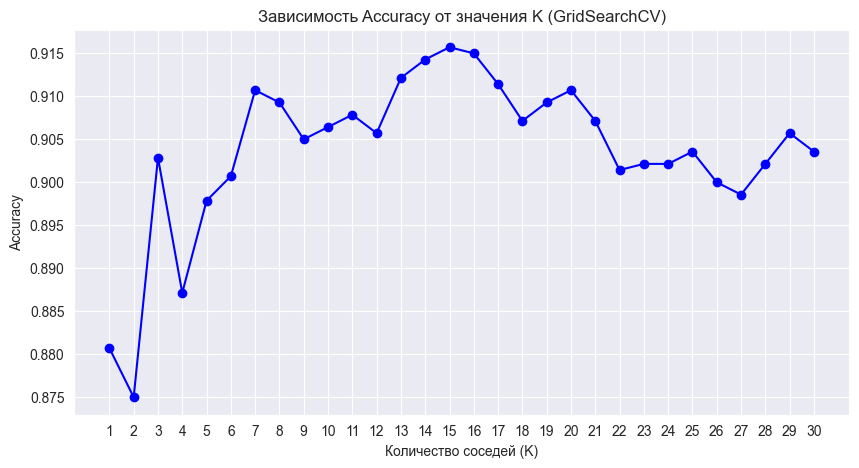

In [8]:
# Получаем значения K и соответствующие accuracy из результатов GridSearchCV
k_values = param_grid['n_neighbors']
accuracy_scores = grid_search.cv_results_['mean_test_score']

# Строим график
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-', color='blue')
plt.title('Зависимость Accuracy от значения K (GridSearchCV)')
plt.xlabel('Количество соседей (K)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(k_values)
plt.show()


#### Подбор гиперпараметра K с RandomizedSearchCV (стратегия StratifiedKFold)

In [9]:
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    KNeighborsClassifier(), param_grid, n_iter=10, cv=cv_stratified,
    scoring='accuracy', random_state=42
)
random_search.fit(X_train, y_train)

print("\n--- RandomizedSearchCV ---")
print("Best parameters:", random_search.best_params_["n_neighbors"])
print("Best score (accuracy):", random_search.best_score_)


--- RandomizedSearchCV ---
Best parameters: 9
Best score (accuracy): 0.9164285714285715


#### Оценка лучшей модели (из GridSearchCV)

In [10]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("\n--- Метрики оптимальной модели ---")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision (macro):", precision_score(y_test, y_pred_best, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_best, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred_best, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred_best))


--- Метрики оптимальной модели ---
Accuracy: 0.9333333333333333
Precision (macro): 0.9333762982058462
Recall (macro): 0.9333333333333332
F1-score (macro): 0.9333496298107016
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       150
           1       0.92      0.93      0.92       150
           2       0.89      0.89      0.89       150
           3       0.95      0.94      0.94       150

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



#### Визуализация confusion matrix для лучшей модели

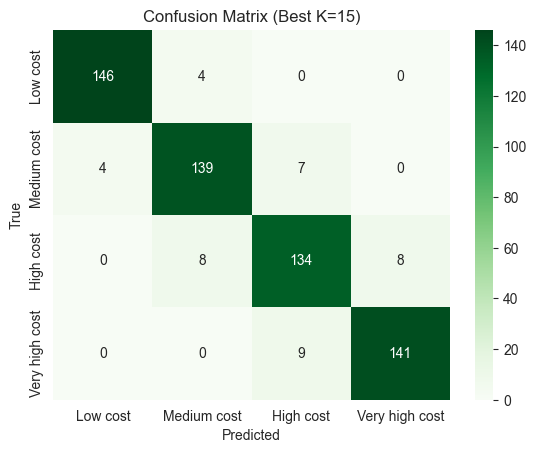

In [11]:
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix (Best K={grid_search.best_params_["n_neighbors"]})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()